In [1]:
# imports for SQL data part
import pyodbc
from datetime import datetime, timedelta
import pandas as pd

# imports for sending email
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import smtplib

import numpy as np

#import vpython as vs # Supplementary code
#from sklearn.model_selection import ShuffleSplit
import seaborn as sns
from scipy.stats import norm
from sklearn import metrics,preprocessing
import matplotlib.pyplot as plt
from scipy import stats
#import re
#from sklearn.metrics import mean_squared_error
#import xgboost as xgb


from matplotlib.dates import AutoDateLocator, DateFormatter  

cnxn_str = ("Driver={SQL Server Native Client 11.0};"
            "Server=MSI\\ZYB_SERVER;"
            "Database=InventoryManagementSystem;"
            "Trusted_Connection=yes")

cnxn = pyodbc.connect(cnxn_str)  # initialise connection (assume we have already defined cnxn_str)

# build up our query string
query = ("SELECT distinct PurchaseOrderSupplierProducts.PurchaseOrderId, "
         "PurchaseOrders.POIssueDate, "
         "PurchaseOrders.expectedDeliveryDate,"
         "DeliveryOrders.DOReceivedDate, "
         "PurchaseOrders.POCode,"
         "DeliveryOrders.DOCode, "
         "PurchaseOrderSupplierProducts.SupplierProductId, "
         "PurchaseOrderSupplierProducts.POUnitPrice,"
         "PurchaseOrderSupplierProducts.POQuantityRequested,"
         "DeliveryOrderSupplierProducts.DOQuantityReceived,"
         "Products.ProductName,"
         "Products.ReorderQuantity,"
         "Products.MLReorderQuantity,"
         "ProductCategories.ProductCategoryName "
         "FROM [InventoryManagementSystem].[dbo].[PurchaseOrders] "
         "INNER JOIN [InventoryManagementSystem].[dbo].[PurchaseOrderSupplierProducts] "
         "ON PurchaseOrders.Id=PurchaseOrderSupplierProducts.PurchaseOrderId "
         "INNER JOIN [InventoryManagementSystem].[dbo].[SupplierProducts] "
         "ON PurchaseOrderSupplierProducts.SupplierProductId=SupplierProducts.Id "
         "INNER JOIN [InventoryManagementSystem].[dbo].[Products] "
         "ON SupplierProducts.ProductId=Products.Id "
         "INNER JOIN [InventoryManagementSystem].[dbo].[ProductCategories] "
         "ON ProductCategories.Id=Products.ProductCategoryId "
         "INNER JOIN [InventoryManagementSystem].[dbo].[DeliveryOrders] "
         "ON DeliveryOrders.PurchaseOrderId=PurchaseOrders.Id "
         "INNER JOIN [InventoryManagementSystem].[dbo].[DeliveryOrderSupplierProducts] "
         "ON DeliveryOrderSupplierProducts.PurchaseOrderSupplierProductId=PurchaseOrderSupplierProducts.Id "
         "WHERE PurchaseOrders.Id BETWEEN 1 AND 1000")

# execute the query and read to a dataframe in Python
data = pd.read_sql(query, cnxn)

# close the connection
del cnxn


count_row=data.shape[0]
count_col=data.shape[1]


print("Number of Columns:  ",count_col)
print("Size of data:  ",count_row)
data.head()



Number of Columns:   14
Size of data:   992


,PurchaseOrderId,POIssueDate,expectedDeliveryDate,DOReceivedDate,POCode,DOCode,SupplierProductId,POUnitPrice,POQuantityRequested,DOQuantityReceived,ProductName,ReorderQuantity,MLReorderQuantity,ProductCategoryName
0,5,2020-08-27 06:45:52.084586,2020-09-06 06:45:52.084576,2020-08-27 06:46:38.269951,PO/270820/2,DO/270820/1,162,10.00,50,50,Exercise Book A4 Hardcover (120 pg),50,203,Exercise
1,6,2020-08-27 06:45:52.096139,2020-09-06 06:45:52.096132,2020-08-27 06:47:21.727837,PO/270820/3,DO/270820/2,55,3.05,50,20,Pencil 2B,50,224,Pen
2,11,2019-09-08 22:38:12.000000,2019-09-15 22:38:12.000000,2019-09-18 21:24:17.000000,PO/080919/1,DO/180919/1,16,6.08,400,400,"Envelope White (5""x7"")",400,221,Envelope
3,12,2020-01-12 18:16:50.000000,2020-01-19 18:16:50.000000,2020-01-17 00:56:15.000000,PO/120120/1,DO/170120/1,94,8.08,50,50,Pencil 2B with Eraser End,50,39,Pen
4,13,2020-03-14 09:26:48.000000,2020-03-21 09:26:48.000000,2020-03-20 13:51:43.000000,PO/140320/1,DO/200320/1,66,16.01,50,50,Pen Whiteboard Marker Green,50,174,Pen


In [2]:
data.tail()

,PurchaseOrderId,POIssueDate,expectedDeliveryDate,DOReceivedDate,POCode,DOCode,SupplierProductId,POUnitPrice,POQuantityRequested,DOQuantityReceived,ProductName,ReorderQuantity,MLReorderQuantity,ProductCategoryName
987,996,2017-02-01 11:21:53,2017-02-08 11:21:53,2017-02-09 04:14:02,PO/010217/1,DO/090217/1,122,7.05,20,20,Scotch Tape Dispenser,20,80,Tape
988,997,2020-06-27 06:16:05,2020-07-04 06:16:05,2020-07-02 20:10:19,PO/270620/1,DO/020720/1,79,8.07,50,50,Exercise Book A4 Hardcover (100 pg),50,166,Exercise
989,998,2017-08-20 15:47:33,2017-08-27 15:47:33,2017-08-27 08:47:35,PO/200817/1,DO/270817/1,19,6.02,50,50,File Separator,50,32,File
990,999,2018-09-24 21:08:28,2018-10-01 21:08:28,2018-10-02 23:10:22,PO/240918/1,DO/021018/1,91,8.01,50,50,Pen Ballpoint Red,50,28,Pen
991,1000,2019-04-25 16:42:24,2019-05-02 16:42:24,2019-05-05 04:55:18,PO/250419/1,DO/050519/1,163,10.09,400,400,"Envelope Brown (5""x7"")",400,27,Envelope


In [3]:
cat = len(data.drop(['PurchaseOrderId','MLReorderQuantity'],axis=1).select_dtypes(include=['object']).columns)
num = len(data.drop(['PurchaseOrderId','MLReorderQuantity'],axis=1).select_dtypes(include=['int64','float64']).columns)
tim = len(data.drop(['PurchaseOrderId','MLReorderQuantity'],axis=1).select_dtypes(include=['datetime64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical','+',tim, 'time', '=', cat+num+tim, 'features')

Total Features:  4 categorical + 5 numerical + 3 time = 12 features


In [4]:
data.drop(['PurchaseOrderId'],axis=1).describe()

,SupplierProductId,POUnitPrice,POQuantityRequested,DOQuantityReceived,ReorderQuantity,MLReorderQuantity
count,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000
mean,128.026210,7.585282,104.788306,104.758065,104.788306,143.307460
std,75.738485,4.768594,125.249118,125.265981,125.249118,86.406796
min,1.000000,2.010000,10.000000,10.000000,10.000000,15.000000
25%,66.000000,3.080000,30.000000,30.000000,30.000000,64.000000
50%,125.000000,7.050000,50.000000,50.000000,50.000000,137.000000
75%,188.000000,10.060000,100.000000,100.000000,100.000000,213.000000
max,261.000000,16.100000,500.000000,500.000000,500.000000,300.000000


In [5]:
data['ProductCategoryName'].unique()

array(['Exercise', 'Pen', 'Envelope', 'Pad', 'File', 'Tape', 'Tparency',
       'Clip', 'Shorthand', 'Puncher', 'Tacks', 'Stapler', 'Eraser',
       'Tray', 'Scissors', 'Sharpener', 'Paper', 'Ruler'], dtype=object)


 mu = 7.59 and sigma = 4.77



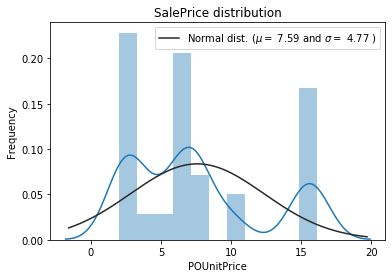

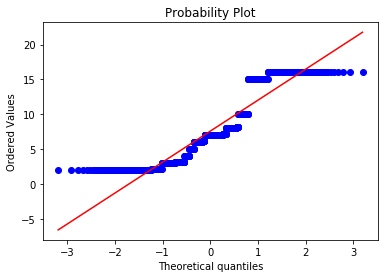

Skewness: 0.657370
Kurtosis: -0.837559


In [6]:
#sns.distplot(data['POUnitPrice'] , fit=norm);
sns.distplot(data['POUnitPrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['POUnitPrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(data['POUnitPrice'], plot=plt)
plt.show()

print("Skewness: %f" % data['POUnitPrice'].skew())
print("Kurtosis: %f" % data['POUnitPrice'].kurt())

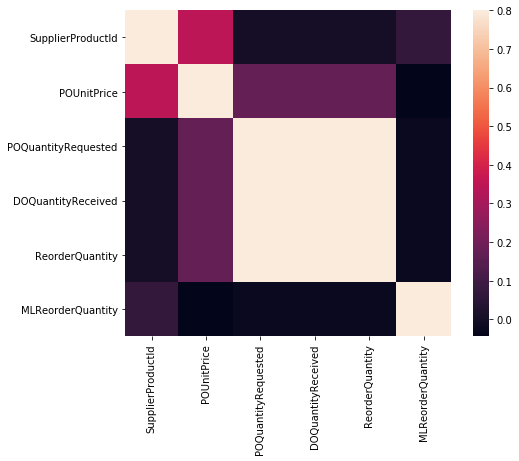

In [7]:
# Correlation Matrix Heatmap of 8 numerical features
corrmat = data.drop(['PurchaseOrderId'],axis=1).corr()
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corrmat, vmax=.8, square=True);

In [8]:
data_time_quantity=data[['POIssueDate','POQuantityRequested','ProductName','ProductCategoryName']]
data_time_quantity.head()

,POIssueDate,POQuantityRequested,ProductName,ProductCategoryName
0,2020-08-27 06:45:52.084586,50,Exercise Book A4 Hardcover (120 pg),Exercise
1,2020-08-27 06:45:52.096139,50,Pencil 2B,Pen
2,2019-09-08 22:38:12.000000,400,"Envelope White (5""x7"")",Envelope
3,2020-01-12 18:16:50.000000,50,Pencil 2B with Eraser End,Pen
4,2020-03-14 09:26:48.000000,50,Pen Whiteboard Marker Green,Pen


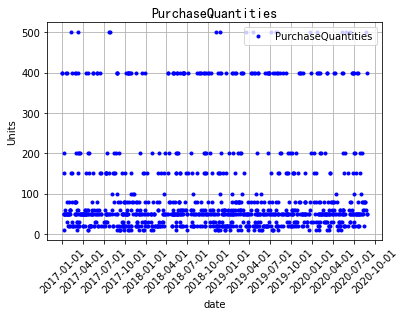

In [9]:
df = pd.DataFrame(data[['POIssueDate','POQuantityRequested']])
plt.plot_date(df.POIssueDate, df.POQuantityRequested, fmt='b.')

ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))  
ax.xaxis.set_major_locator(AutoDateLocator(maxticks=24))       

plt.xticks(rotation=45, ha='center')
label = ['PurchaseQuantities']
plt.legend(label, loc='upper right')

plt.grid()

ax.set_title(u'PurchaseQuantities', fontproperties='SimHei',fontsize=14)  
ax.set_xlabel('date')
ax.set_ylabel('Units')



plt.show()


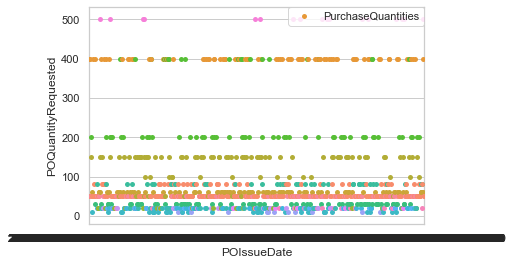

In [10]:
sns.set(style="whitegrid")


sns.stripplot(x="POIssueDate", y="POQuantityRequested", hue="ProductCategoryName",
              data=data_time_quantity, jitter=True)
plt.legend(label, loc='upper right', borderaxespad=0.)
plt.show()

In [11]:
#Date and Time getting
data['Date_PO']=data['POIssueDate'].dt.date
data['Time_PO']=data['POIssueDate'].dt.time
data['Date_DO']=data['DOReceivedDate'].dt.date
data['Time_DO']=data['DOReceivedDate'].dt.time
data['Date_eDO']=data['expectedDeliveryDate'].dt.date
data['Time_eDO']=data['expectedDeliveryDate'].dt.time
data['Date_PO_Week_year']=data['POIssueDate'].dt.weekofyear
data['Date_DO_Week_year']=data['DOReceivedDate'].dt.weekofyear
data['Date_PO_year']=data['POIssueDate'].dt.year
data['Date_PO_quarter']=data['POIssueDate'].dt.quarter
data['Date_PO_month']=data['POIssueDate'].dt.month
data['Date_PO_week']=data['POIssueDate'].dt.week
data['Date_PO_day']=data['POIssueDate'].dt.day

data.head()

,PurchaseOrderId,POIssueDate,expectedDeliveryDate,DOReceivedDate,POCode,DOCode,SupplierProductId,POUnitPrice,POQuantityRequested,DOQuantityReceived,...,Time_DO,Date_eDO,Time_eDO,Date_PO_Week_year,Date_DO_Week_year,Date_PO_year,Date_PO_quarter,Date_PO_month,Date_PO_week,Date_PO_day
0,5,2020-08-27 06:45:52.084586,2020-09-06 06:45:52.084576,2020-08-27 06:46:38.269951,PO/270820/2,DO/270820/1,162,10.00,50,50,...,06:46:38.269951,2020-09-06,06:45:52.084576,35,35,2020,3,8,35,27
1,6,2020-08-27 06:45:52.096139,2020-09-06 06:45:52.096132,2020-08-27 06:47:21.727837,PO/270820/3,DO/270820/2,55,3.05,50,20,...,06:47:21.727837,2020-09-06,06:45:52.096132,35,35,2020,3,8,35,27
2,11,2019-09-08 22:38:12.000000,2019-09-15 22:38:12.000000,2019-09-18 21:24:17.000000,PO/080919/1,DO/180919/1,16,6.08,400,400,...,21:24:17,2019-09-15,22:38:12,36,38,2019,3,9,36,8
3,12,2020-01-12 18:16:50.000000,2020-01-19 18:16:50.000000,2020-01-17 00:56:15.000000,PO/120120/1,DO/170120/1,94,8.08,50,50,...,00:56:15,2020-01-19,18:16:50,2,3,2020,1,1,2,12
4,13,2020-03-14 09:26:48.000000,2020-03-21 09:26:48.000000,2020-03-20 13:51:43.000000,PO/140320/1,DO/200320/1,66,16.01,50,50,...,13:51:43,2020-03-21,09:26:48,11,12,2020,1,3,11,14


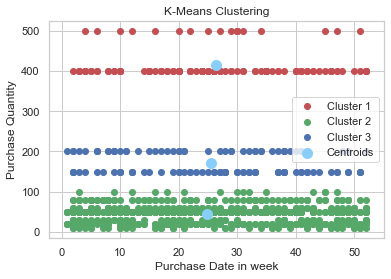

In [12]:
from sklearn.cluster import KMeans
#KMeans
x = data.iloc[:, [20,8,7]].values

#Applying kmeans to the dataset / Creating the kmeans classifier
kmeans = KMeans(n_clusters = 3)
clusters = kmeans.fit_predict(x)

#2D plot
colors = 'rgbkcmy'

for i in np.unique(clusters):
    plt.scatter(x[clusters==i,0], x[clusters==i,1],
                color=colors[i], label='Cluster ' + str(i + 1))

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1],
            s=100, c='lightskyblue', label='Centroids')
plt.legend()
plt.title('K-Means Clustering')
plt.xlabel('Purchase Date in week')
plt.ylabel('Purchase Quantity')
plt.show()


In [13]:
# Set up Category list

for i in data['ProductCategoryName']:

    pc0 = data[data['ProductCategoryName'] == data['ProductCategoryName'].unique()[0]]
    pc1 = data[data['ProductCategoryName'] == data['ProductCategoryName'].unique()[1]]
    pc2 = data[data['ProductCategoryName'] == data['ProductCategoryName'].unique()[2]]
    pc3 = data[data['ProductCategoryName'] == data['ProductCategoryName'].unique()[3]]
    pc4 = data[data['ProductCategoryName'] == data['ProductCategoryName'].unique()[4]]
    pc5 = data[data['ProductCategoryName'] == data['ProductCategoryName'].unique()[5]]
    pc6 = data[data['ProductCategoryName'] == data['ProductCategoryName'].unique()[6]]
    pc7 = data[data['ProductCategoryName'] == data['ProductCategoryName'].unique()[7]]
    pc8 = data[data['ProductCategoryName'] == data['ProductCategoryName'].unique()[8]]
    pc9 = data[data['ProductCategoryName'] == data['ProductCategoryName'].unique()[9]]
    pc10 = data[data['ProductCategoryName'] == data['ProductCategoryName'].unique()[10]]
    pc11 = data[data['ProductCategoryName'] == data['ProductCategoryName'].unique()[11]]
    pc12 = data[data['ProductCategoryName'] == data['ProductCategoryName'].unique()[12]]
    pc13 = data[data['ProductCategoryName'] == data['ProductCategoryName'].unique()[13]]


pc=[pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13]


pc0_sum=pc0.sum(axis=0,skipna=True)['POQuantityRequested']
pc1_sum=pc1.sum(axis=0,skipna=True)['POQuantityRequested']
pc2_sum=pc2.sum(axis=0,skipna=True)['POQuantityRequested']
pc3_sum=pc3.sum(axis=0,skipna=True)['POQuantityRequested']
pc4_sum=pc4.sum(axis=0,skipna=True)['POQuantityRequested']
pc5_sum=pc5.sum(axis=0,skipna=True)['POQuantityRequested']
pc6_sum=pc6.sum(axis=0,skipna=True)['POQuantityRequested']
pc7_sum=pc7.sum(axis=0,skipna=True)['POQuantityRequested']
pc8_sum=pc8.sum(axis=0,skipna=True)['POQuantityRequested']
pc9_sum=pc9.sum(axis=0,skipna=True)['POQuantityRequested']
pc10_sum=pc10.sum(axis=0,skipna=True)['POQuantityRequested']
pc11_sum=pc11.sum(axis=0,skipna=True)['POQuantityRequested']
pc12_sum=pc12.sum(axis=0,skipna=True)['POQuantityRequested']
pc13_sum=pc13.sum(axis=0,skipna=True)['POQuantityRequested']

pc_sum=[pc0_sum,pc1_sum,pc2_sum,pc3_sum,pc4_sum,pc5_sum,pc6_sum,pc7_sum,pc8_sum,pc9_sum,pc10_sum,pc11_sum,pc12_sum,pc13_sum]



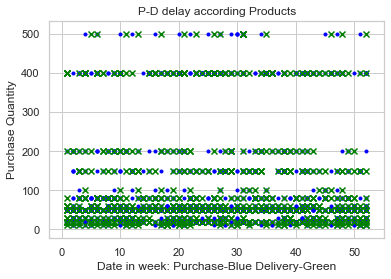

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Linear 1.plot

advert = data[['Date_PO_Week_year']]
sales = data['POQuantityRequested'] # This is the same as

x_train = advert
y_train = sales

#instantiate
linReg = LinearRegression()

linReg.fit(x_train, y_train)

y_pred = linReg.predict(x_train)
r2_score(y_train, y_pred)

plt.scatter(x_train, y_train, color='blue', marker=".")


plt.title('P-D delay according Products')
plt.xlabel('Date in week: Purchase-Blue Delivery-Green')
plt.ylabel('Purchase Quantity')


advert_pc = data[['Date_DO_Week_year']]
sales_pc = data['POQuantityRequested'] # This is the same as

x_train_pc = advert_pc
y_train_pc = sales_pc

#instantiate
linReg = LinearRegression()

linReg.fit(x_train_pc, y_train_pc)


y_pred_pc = linReg.predict(x_train_pc)
r2_score(y_train_pc, y_pred_pc)

plt.scatter(x_train_pc, y_train_pc, color='green', marker="x")
plt.show()


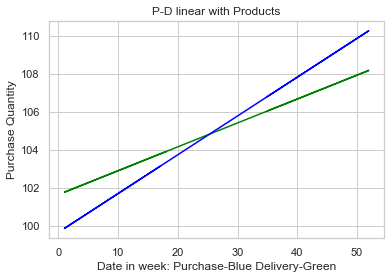

In [15]:

plt.plot(x_train_pc, y_pred_pc, color='green')
plt.plot(x_train, y_pred, color='blue')

plt.title('P-D linear with Products')
plt.xlabel('Date in week: Purchase-Blue Delivery-Green')
plt.ylabel('Purchase Quantity')
plt.show()

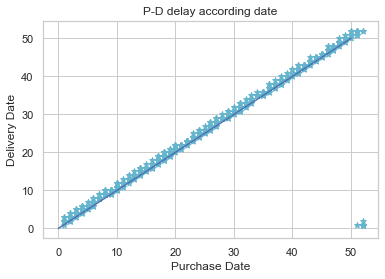

In [16]:

plt.scatter(x_train, x_train_pc, color="c",marker="*")
plt.plot( [0,50],[0,50] )

plt.title('P-D delay according date')
plt.ylabel('Delivery Date')
plt.xlabel('Purchase Date')
plt.show()

In [17]:

#instantiate
linReg = LinearRegression()
linReg.fit(x_train, x_train_pc)
print("intercept: ",linReg.intercept_)
print("coef: ",linReg.coef_)
print("score: ",linReg.score(x_train_pc, x_train))
print("if purchase at 25th week will delay(week): " ,linReg.predict([[15]])-15)



intercept:  [3.24911541]
coef:  [[0.86672322]]
score:  0.765016911567174
if purchase at 25th week will delay(week):  [[1.24996365]]


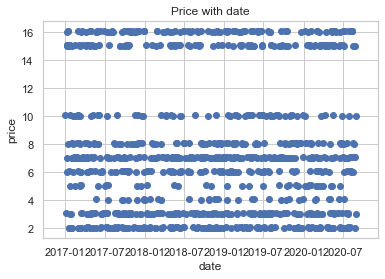

In [18]:

cl=data['POUnitPrice']
cb=data['POIssueDate']
plt.scatter(cb,cl)
plt.title('Price with date')
plt.xlabel('date')
plt.ylabel('price')
plt.show()